# EE 467 Lab 4: Autoencoder and Clustering

In this lab, we will continue to learn two classes of unsupervised machine learning algorithms-dimensionality reduction and clustering. These algorithms can help us figure out previously unknown patterns in the features without any kind of labels. We will apply these algorithms to the KDD Cup 1999 network intrusion dataset and visualize their results. These results may reflect differences in the characteristics of malicious and normal network connections from an alternative perspective.

## Dataset

We will work on the KDD Cup 1999 network intrusion dataset for this lab. The KDD Cup 1999 dataset consists of approximately 4.9 million records of network connections. Here a connection is a sequence of TCP packets starting and ending at some well defined times, during which data flows to and from a source IP address to a target IP address under some well defined protocol. Each connection contains 41 features and is labeled as either normal or an attack, with exactly one specific attack type. The original goal of the contest is to predictive model (i.e. a classifier) capable of distinguishing between malicious connections, called intrusions or attacks, and good normal connections.

Attacks in the KDD Cup 1999 dataset fall into four main categories:

1. DoS: Denial-of-service attacks, e.g. syn flood.
2. R2L: Unauthorized access from a remote machine, e.g. password guessing.
3. U2R: Unauthorized access to local superuser (root) privileges, e.g. privilege escalation through buffer overflow attacks.
4. Probing: surveillance and other probing, e.g. port scanning.

## Prerequisites

Before we begin, install all dependencies needed for this lab:

In [1]:
%pip install torch matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


Then, extract features archive we obtained from the last lab:

## Pre-processing

We have already preformed data pre-processing and dimensionality reduction in the last lab. Here, we load the `StandardScaler`-rescaled features and labels into the memory:

In [2]:
import numpy as np
from sklearn.manifold import TSNE


# Load the three arrays (no t-SNE computation here)
with np.load("./kddcup-1999-pre-processed-data.npz") as data:
    kdd_feat_std = data["kdd_feat_std"]
    kdd_feat_std_tsne = data["kdd_feat_std_tsne"]
    y_std = data["y_std"]

print("kdd_feat_std:", kdd_feat_std.shape)
print("kdd_feat_std_tsne:", kdd_feat_std_tsne.shape)
print("y_std:", y_std.shape)

kdd_feat_std: (24339, 38)
kdd_feat_std_tsne: (24339, 2)
y_std: (24339,)


Like the last lab, we continue to use `visualize_samples` function to plot transformed features in 2D space. Unless specified, we plot normal samples as green dots and malicious samples as orange dots:

Figure(1000x500)


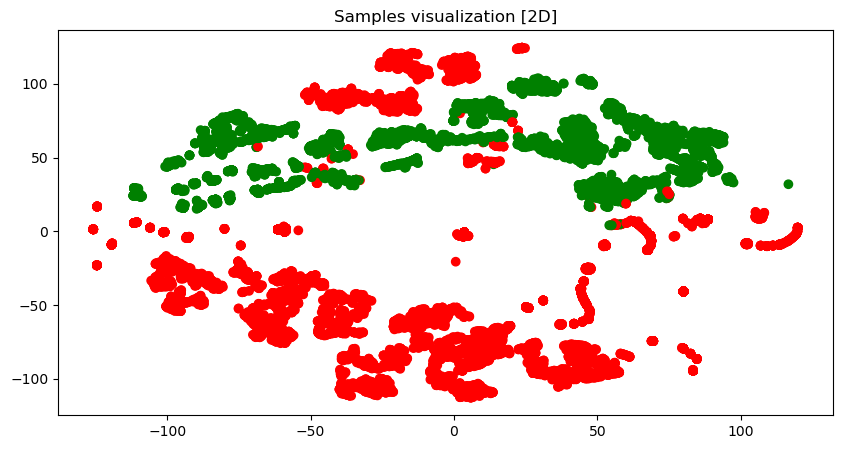

In [3]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_samples(samples, labels, title="Samples visualization", colors=["green", "red"]):
    """ Visualize first three dimensions of samples. """
    # Convert colors to NumPy array
    colors = np.array(colors)
    # Create figure
    fig = plt.figure(figsize=(10, 5))

    # 2D plot
    ax_2d = fig.add_subplot(1, 1, 1)
    ax_2d.set_title(f"{title} [2D]")
    ax_2d.scatter(samples[:, 0], samples[:, 1], c=colors[labels])

    print(fig)

# Visualize `StandardScaler` features (without dimensionality reduction)
visualize_samples(kdd_feat_std_tsne, y_std)

We will also use the following `timeit` function to monitor the training time of machine learning algorithms:

In [4]:
import time
from contextlib import contextmanager

@contextmanager
def timeit(action="Timing"):
    # Record start time
    print(f"{action} started...")
    start_time = time.time()

    # Execute task
    yield

    # Compute and show elapsed time
    elapsed_time = time.time()-start_time
    print(f"{action} completed. Elapsed time: {elapsed_time:.2f}s")

# Test timing function by sleeping for 1 second
with timeit("Testing timing function"):
    time.sleep(1)

Testing timing function started...
Testing timing function completed. Elapsed time: 1.00s


## Autoencoder

We will wrap up the introduction of dimensionality reduction algorithms with autoencoders. An **autoencoder** is a neural network used to learn a compact representation (also called encoding) for a set of data, typically for the purpose of dimensionality reduction. A typical regular autoencoder has a symmetric, five-layer structure shown below:

![Autoencoder Structure](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png)

Like all other neural networks, the first layer is the **input layer** and the **last layer** is the output layer. For an autoencoder, the input layer and the output layer always have the same shape. We call the first three layers of the autoencoder **encoder network** and the last three layers **decoder network**. Hence, the second layer can be seen as the hidden layer of the encoder network and the fourth layer can be seen as the hidden layer of the decoder network. In practice, the shape of these layers are also made same. The third layer is the **encoder output layer**, and we make it the "bottleneck" of the autoencoder (by reducing its dimensions) so that the neural network learns to "compress" the information of previous encoder layers.

The goal of the autoencoder is to learn to **compress and reconstruct input features**, such that the **reconstruction resembles the original input** as much as possible. This forces the autoencoder to focus on the useful properties of the features and discard the noises. After training, we throw away the decoder network and use the encoder network to transform features. The result of the transformation will have fewer dimensions, yet it still preserves the characteristics and properties of the original, high-dimensional inputs.

From a formal perspective, we define the encoder transformation as $\phi: \mathcal{X} \rightarrow \mathcal{F}$ and the decoder transformation as $\psi: \mathcal{F} \rightarrow \mathcal{X}$, where $\mathcal{X}$ is the original feature space and $\mathcal{F}$ is the target feature space. Then the goal of the autoencoder is to minimize the mean-squared loss between the inputs and reconstructions:

$$
l_{AE} = ||X - \psi(\phi(X))||_2^2
$$

After training, we compute $F = \phi(X)$ to obtain target features with reduced dimensions.

Now, let's build an autoencoder in the following `make_ae_models` function. We have given you the dimensions of input features, hidden layers and the encoder output ("bottleneck") layer, as well as the activation layer type. Your task is to create an encoder and a decoder model, **both with three layers (this is different from the figure above!)**, according to the instructions in comments below. The `autoencoder_loss` function handles computation of the autoencoder (mean-squared) loss.

In [5]:
import torch
from torch import nn
from torch.nn import functional as f
from torch.utils.data import DataLoader

def get_torch_device():
    # Use CUDA (Nvidia/AMD GPU) if available
    if torch.cuda.is_available():
        device = "cuda"
    # Use MPS (Apple Silicon GPU) if available
    elif torch.backends.mps.is_available():
        device = "mps"
    # Fallback to CPU
    else:
        device = "cpu"

    return torch.device(device)


def make_ae_models(
    feat_dims, hidden_dims, bottleneck_dims,
    activation=nn.GELU, dropout_ratio=0., device="cpu"
):
    """Create and return both encoder and decoder PyTorch models."""

    # Define encoder model
    encoder_model = nn.Sequential(
        nn.Linear(feat_dims, hidden_dims),
        activation(),
        nn.Dropout(dropout_ratio),
        nn.Linear(hidden_dims, bottleneck_dims),
    )

    # Define decoder model
    decoder_model = nn.Sequential(
        nn.Linear(bottleneck_dims, hidden_dims),
        nn.Dropout(dropout_ratio),
        activation(),
        nn.Linear(hidden_dims, feat_dims),
    )

    # Move models to given PyTorch device
    encoder_model = encoder_model.to(device)
    decoder_model = decoder_model.to(device)

    return encoder_model, decoder_model


def autoencoder_loss(feats, reconstructs, bottlenecks=None, l2_reg_factor=None):
    # Compute mean square error (main) loss between original and reconstructed features
    mse_loss = f.mse_loss(feats, reconstructs)

    # L2 regularization loss for bottleneck features
    if l2_reg_factor:
        l2_reg_loss = bottlenecks.square().sum(-1).mean()
        total_loss = mse_loss+l2_reg_factor*l2_reg_loss
    else:
        total_loss = mse_loss

    return total_loss, mse_loss

We then move on to the implementation of the training loop. This is a simpler version of what we did in lab 3 and homework 2 because no validation is required and thus only a single inner loop needs to be implemented.

In [6]:
from tqdm import tqdm

def train_autoencoder(encoder_model, decoder_model, optimizer, feats, n_epochs, batch_size, l2_reg_factor=0.,
    device=None):
    # Auto-detect PyTorch device from model parameters
    device = device or next(iter(encoder_model.parameters())).device
    # Make data loader for features
    loader = DataLoader(feats, batch_size, shuffle=True)

    for i in range(n_epochs):
        total_loss_epoch = 0.
        mse_loss_epoch = 0.

        print(f"Starting training epoch {i+1}/{n_epochs} ...")

        for feats_batch in tqdm(loader):
            feats_batch = feats.to(device)

            # Forward features through both encoder and decoder,
            # saving bottleneck and reconstructed features in the process
            bottlenecks = encoder_model(feats_batch)
            reconstructs = decoder_model(bottlenecks)
            # Compute autoencoder loss
            total_loss_batch, mse_loss_batch = autoencoder_loss(
                feats_batch, reconstructs, bottlenecks, l2_reg_factor
            )

            # Run an optimizer step
            total_loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Collect statistics
            total_loss_epoch += total_loss_batch.detach().cpu()
            mse_loss_epoch += mse_loss_batch.detach().cpu()

        total_loss_epoch /= len(loader)
        mse_loss_epoch /= len(loader)

        print(f"Training of epoch {i+1}/{n_epochs}: Total loss: {total_loss_epoch.item()}, MSE loss: {mse_loss_epoch.item()}")

Alright, we now have all the components we need to train an autoencoder, and then use it to reduce the dimensionality of our `StandardScaler` features (`kdd_feat_std_tensor`). We will perform these steps, and once we get the bottleneck features from our encoder model, we can visualize them through 2D and 3D plots:

Starting training epoch 1/50 ...


100%|██████████| 96/96 [00:04<00:00, 23.61it/s]


Training of epoch 1/50: Total loss: 0.13895541429519653, MSE loss: 0.13895541429519653
Starting training epoch 2/50 ...


100%|██████████| 96/96 [00:00<00:00, 101.43it/s]


Training of epoch 2/50: Total loss: 0.022042391821742058, MSE loss: 0.022042391821742058
Starting training epoch 3/50 ...


100%|██████████| 96/96 [00:00<00:00, 106.33it/s]


Training of epoch 3/50: Total loss: 0.012500842101871967, MSE loss: 0.012500842101871967
Starting training epoch 4/50 ...


100%|██████████| 96/96 [00:00<00:00, 114.87it/s]


Training of epoch 4/50: Total loss: 0.007736181374639273, MSE loss: 0.007736181374639273
Starting training epoch 5/50 ...


100%|██████████| 96/96 [00:00<00:00, 106.64it/s]


Training of epoch 5/50: Total loss: 0.005162215791642666, MSE loss: 0.005162215791642666
Starting training epoch 6/50 ...


100%|██████████| 96/96 [00:00<00:00, 111.19it/s]


Training of epoch 6/50: Total loss: 0.004153934773057699, MSE loss: 0.004153934773057699
Starting training epoch 7/50 ...


100%|██████████| 96/96 [00:00<00:00, 110.32it/s]


Training of epoch 7/50: Total loss: 0.0038113126065582037, MSE loss: 0.0038113126065582037
Starting training epoch 8/50 ...


100%|██████████| 96/96 [00:00<00:00, 99.35it/s] 


Training of epoch 8/50: Total loss: 0.0036109108477830887, MSE loss: 0.0036109108477830887
Starting training epoch 9/50 ...


100%|██████████| 96/96 [00:01<00:00, 91.67it/s]


Training of epoch 9/50: Total loss: 0.003269635373726487, MSE loss: 0.003269635373726487
Starting training epoch 10/50 ...


100%|██████████| 96/96 [00:00<00:00, 99.86it/s] 


Training of epoch 10/50: Total loss: 0.002820024499669671, MSE loss: 0.002820024499669671
Starting training epoch 11/50 ...


100%|██████████| 96/96 [00:00<00:00, 109.22it/s]


Training of epoch 11/50: Total loss: 0.0026281799655407667, MSE loss: 0.0026281799655407667
Starting training epoch 12/50 ...


100%|██████████| 96/96 [00:00<00:00, 100.93it/s]


Training of epoch 12/50: Total loss: 0.002461085794493556, MSE loss: 0.002461085794493556
Starting training epoch 13/50 ...


100%|██████████| 96/96 [00:01<00:00, 94.60it/s] 


Training of epoch 13/50: Total loss: 0.0023332806304097176, MSE loss: 0.0023332806304097176
Starting training epoch 14/50 ...


100%|██████████| 96/96 [00:01<00:00, 91.37it/s] 


Training of epoch 14/50: Total loss: 0.0021853100042790174, MSE loss: 0.0021853100042790174
Starting training epoch 15/50 ...


100%|██████████| 96/96 [00:00<00:00, 107.37it/s]


Training of epoch 15/50: Total loss: 0.002106520114466548, MSE loss: 0.002106520114466548
Starting training epoch 16/50 ...


100%|██████████| 96/96 [00:00<00:00, 103.49it/s]


Training of epoch 16/50: Total loss: 0.0020151729695498943, MSE loss: 0.0020151729695498943
Starting training epoch 17/50 ...


100%|██████████| 96/96 [00:00<00:00, 107.84it/s]


Training of epoch 17/50: Total loss: 0.001986871240660548, MSE loss: 0.001986871240660548
Starting training epoch 18/50 ...


100%|██████████| 96/96 [00:00<00:00, 101.57it/s]


Training of epoch 18/50: Total loss: 0.0019462760537862778, MSE loss: 0.0019462760537862778
Starting training epoch 19/50 ...


100%|██████████| 96/96 [00:00<00:00, 109.53it/s]


Training of epoch 19/50: Total loss: 0.0018898509442806244, MSE loss: 0.0018898509442806244
Starting training epoch 20/50 ...


100%|██████████| 96/96 [00:00<00:00, 105.36it/s]


Training of epoch 20/50: Total loss: 0.0018861383432522416, MSE loss: 0.0018861383432522416
Starting training epoch 21/50 ...


100%|██████████| 96/96 [00:00<00:00, 97.86it/s] 


Training of epoch 21/50: Total loss: 0.001863886951468885, MSE loss: 0.001863886951468885
Starting training epoch 22/50 ...


100%|██████████| 96/96 [00:00<00:00, 96.18it/s]


Training of epoch 22/50: Total loss: 0.0017841487424448133, MSE loss: 0.0017841487424448133
Starting training epoch 23/50 ...


100%|██████████| 96/96 [00:00<00:00, 103.03it/s]


Training of epoch 23/50: Total loss: 0.0017719654133543372, MSE loss: 0.0017719654133543372
Starting training epoch 24/50 ...


100%|██████████| 96/96 [00:00<00:00, 99.79it/s] 


Training of epoch 24/50: Total loss: 0.001741493004374206, MSE loss: 0.001741493004374206
Starting training epoch 25/50 ...


100%|██████████| 96/96 [00:00<00:00, 102.18it/s]


Training of epoch 25/50: Total loss: 0.0017131813801825047, MSE loss: 0.0017131813801825047
Starting training epoch 26/50 ...


100%|██████████| 96/96 [00:00<00:00, 105.38it/s]


Training of epoch 26/50: Total loss: 0.0016909161349758506, MSE loss: 0.0016909161349758506
Starting training epoch 27/50 ...


100%|██████████| 96/96 [00:00<00:00, 99.05it/s] 


Training of epoch 27/50: Total loss: 0.001658177119679749, MSE loss: 0.001658177119679749
Starting training epoch 28/50 ...


100%|██████████| 96/96 [00:00<00:00, 97.83it/s] 


Training of epoch 28/50: Total loss: 0.001623761490918696, MSE loss: 0.001623761490918696
Starting training epoch 29/50 ...


100%|██████████| 96/96 [00:00<00:00, 96.19it/s] 


Training of epoch 29/50: Total loss: 0.001605055294930935, MSE loss: 0.001605055294930935
Starting training epoch 30/50 ...


100%|██████████| 96/96 [00:00<00:00, 98.85it/s] 


Training of epoch 30/50: Total loss: 0.0015573919517919421, MSE loss: 0.0015573919517919421
Starting training epoch 31/50 ...


100%|██████████| 96/96 [00:00<00:00, 118.21it/s]


Training of epoch 31/50: Total loss: 0.0015600736951455474, MSE loss: 0.0015600736951455474
Starting training epoch 32/50 ...


100%|██████████| 96/96 [00:00<00:00, 104.35it/s]


Training of epoch 32/50: Total loss: 0.0015407513128593564, MSE loss: 0.0015407513128593564
Starting training epoch 33/50 ...


100%|██████████| 96/96 [00:00<00:00, 101.64it/s]


Training of epoch 33/50: Total loss: 0.0015283649554476142, MSE loss: 0.0015283649554476142
Starting training epoch 34/50 ...


100%|██████████| 96/96 [00:01<00:00, 94.55it/s]


Training of epoch 34/50: Total loss: 0.001524500665254891, MSE loss: 0.001524500665254891
Starting training epoch 35/50 ...


100%|██████████| 96/96 [00:00<00:00, 103.02it/s]


Training of epoch 35/50: Total loss: 0.0015171883860602975, MSE loss: 0.0015171883860602975
Starting training epoch 36/50 ...


100%|██████████| 96/96 [00:00<00:00, 109.24it/s]


Training of epoch 36/50: Total loss: 0.0015025906031951308, MSE loss: 0.0015025906031951308
Starting training epoch 37/50 ...


100%|██████████| 96/96 [00:00<00:00, 110.13it/s]


Training of epoch 37/50: Total loss: 0.0014896979555487633, MSE loss: 0.0014896979555487633
Starting training epoch 38/50 ...


100%|██████████| 96/96 [00:00<00:00, 98.81it/s] 


Training of epoch 38/50: Total loss: 0.0014754602452740073, MSE loss: 0.0014754602452740073
Starting training epoch 39/50 ...


100%|██████████| 96/96 [00:00<00:00, 98.89it/s] 


Training of epoch 39/50: Total loss: 0.0014492548070847988, MSE loss: 0.0014492548070847988
Starting training epoch 40/50 ...


100%|██████████| 96/96 [00:00<00:00, 98.10it/s] 


Training of epoch 40/50: Total loss: 0.0014674932463094592, MSE loss: 0.0014674932463094592
Starting training epoch 41/50 ...


100%|██████████| 96/96 [00:00<00:00, 101.08it/s]


Training of epoch 41/50: Total loss: 0.0014636259293183684, MSE loss: 0.0014636259293183684
Starting training epoch 42/50 ...


100%|██████████| 96/96 [00:00<00:00, 100.08it/s]


Training of epoch 42/50: Total loss: 0.0014373863814398646, MSE loss: 0.0014373863814398646
Starting training epoch 43/50 ...


100%|██████████| 96/96 [00:00<00:00, 106.62it/s]


Training of epoch 43/50: Total loss: 0.0014552335487678647, MSE loss: 0.0014552335487678647
Starting training epoch 44/50 ...


100%|██████████| 96/96 [00:00<00:00, 102.67it/s]


Training of epoch 44/50: Total loss: 0.0014145285822451115, MSE loss: 0.0014145285822451115
Starting training epoch 45/50 ...


100%|██████████| 96/96 [00:00<00:00, 112.42it/s]


Training of epoch 45/50: Total loss: 0.0014186428161337972, MSE loss: 0.0014186428161337972
Starting training epoch 46/50 ...


100%|██████████| 96/96 [00:00<00:00, 97.77it/s] 


Training of epoch 46/50: Total loss: 0.0014413314638659358, MSE loss: 0.0014413314638659358
Starting training epoch 47/50 ...


100%|██████████| 96/96 [00:00<00:00, 102.45it/s]


Training of epoch 47/50: Total loss: 0.0013967846753075719, MSE loss: 0.0013967846753075719
Starting training epoch 48/50 ...


100%|██████████| 96/96 [00:00<00:00, 106.11it/s]


Training of epoch 48/50: Total loss: 0.001424978137947619, MSE loss: 0.001424978137947619
Starting training epoch 49/50 ...


100%|██████████| 96/96 [00:00<00:00, 99.85it/s] 


Training of epoch 49/50: Total loss: 0.0014056904474273324, MSE loss: 0.0014056904474273324
Starting training epoch 50/50 ...


100%|██████████| 96/96 [00:00<00:00, 107.34it/s]


Training of epoch 50/50: Total loss: 0.0013762390008196235, MSE loss: 0.0013762390008196235
Figure(1000x500)


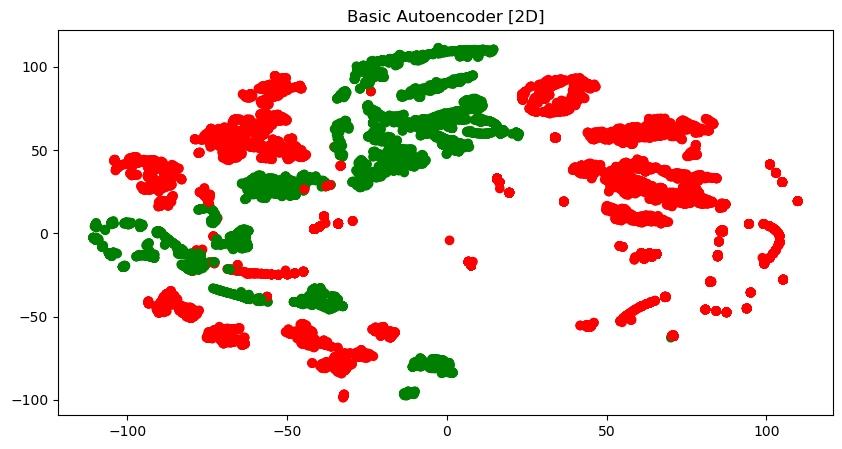

In [7]:
from itertools import chain

from torch.optim import AdamW

# Get preferred PyTorch device
torch_device = get_torch_device()
# Convert `kdd_feat_std` to PyTorch tensor, and put tensor on selected device
kdd_feat_std_tensor = torch.tensor(kdd_feat_std, device=torch_device, dtype=torch.float32)

# Make basic autoencoder models
enc_model_1, dec_model_1 = make_ae_models(
    feat_dims=kdd_feat_std.shape[1],
    hidden_dims=20,
    bottleneck_dims=10,
    device=torch_device
)
# Create optimizer for autoencoder models
optimizer = AdamW(
    chain(enc_model_1.parameters(), dec_model_1.parameters()),
    lr=0.005
)

# Train basic autoencoder models
train_autoencoder(
    enc_model_1, dec_model_1, optimizer, kdd_feat_std_tensor, n_epochs=50, batch_size=256
)
# Perform dimensionality reduction with the encoder
with torch.inference_mode():
    kdd_feat_ae_1 = enc_model_1(kdd_feat_std_tensor)
    kdd_feat_ae_1 = kdd_feat_ae_1.cpu().numpy()

# Run 2D t-SNE on StandardScaler features
autoenc_tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42,
)

kdd_feat_ae_1_tsne = autoenc_tsne.fit_transform(kdd_feat_ae_1)

# Plot basic autoencoder bottleneck features
visualize_samples(kdd_feat_ae_1_tsne, y_std, title="Basic Autoencoder")

Now that we have successfully trained our first autoencoder and transformed `StandardScaler` features to 10D space, we can try a few measures to improve it. First, we are going to **increase the capacity of the hidden layers** of our autoencoder. However, simply enlarging linear layers could make the autoencoder training more likely to overfit. Thus, we will **apply dropout** for the encoder and the decoder each. Another possible mitigation for the overfitting issue is **regularization**, which we will add to the encoder output so that the autoencoder loss becomes:

$$
l_{AE-L2} = ||X - \psi(\phi(X))||_2^2 + \lambda ||\phi(X)||_2^2
$$

To apply these improvements, go back to the `make_ae_models` function, then add [`torch.nn.Dropout`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layers between existing linear and activation layers. The L2 regularization is already implemented in `autoencoder_loss`, and you can enable it by forwarding the `l2_reg_factor` parameter for your `train_autoencoder` function. Finally, play with the hidden layer sizes, dropout ratio and L2 output regularization strength to see how the output features generated by the enhanced autoencoder actually look like.

Starting training epoch 1/50 ...


100%|██████████| 96/96 [00:02<00:00, 45.34it/s]


Training of epoch 1/50: Total loss: 0.12329346686601639, MSE loss: 0.11914994567632675
Starting training epoch 2/50 ...


100%|██████████| 96/96 [00:00<00:00, 98.96it/s] 


Training of epoch 2/50: Total loss: 0.04330601170659065, MSE loss: 0.04093224182724953
Starting training epoch 3/50 ...


100%|██████████| 96/96 [00:00<00:00, 108.45it/s]


Training of epoch 3/50: Total loss: 0.03511948511004448, MSE loss: 0.03334721922874451
Starting training epoch 4/50 ...


100%|██████████| 96/96 [00:00<00:00, 98.49it/s] 


Training of epoch 4/50: Total loss: 0.03099968284368515, MSE loss: 0.029503002762794495
Starting training epoch 5/50 ...


100%|██████████| 96/96 [00:01<00:00, 93.46it/s] 


Training of epoch 5/50: Total loss: 0.0287051722407341, MSE loss: 0.027426710352301598
Starting training epoch 6/50 ...


100%|██████████| 96/96 [00:00<00:00, 96.71it/s] 


Training of epoch 6/50: Total loss: 0.027509452775120735, MSE loss: 0.026401184499263763
Starting training epoch 7/50 ...


100%|██████████| 96/96 [00:00<00:00, 109.56it/s]


Training of epoch 7/50: Total loss: 0.02672025002539158, MSE loss: 0.02571997232735157
Starting training epoch 8/50 ...


100%|██████████| 96/96 [00:00<00:00, 101.85it/s]


Training of epoch 8/50: Total loss: 0.02595704235136509, MSE loss: 0.025029189884662628
Starting training epoch 9/50 ...


100%|██████████| 96/96 [00:00<00:00, 100.86it/s]


Training of epoch 9/50: Total loss: 0.025591278448700905, MSE loss: 0.02472587861120701
Starting training epoch 10/50 ...


100%|██████████| 96/96 [00:01<00:00, 80.69it/s]


Training of epoch 10/50: Total loss: 0.02519500069320202, MSE loss: 0.024376848712563515
Starting training epoch 11/50 ...


100%|██████████| 96/96 [00:00<00:00, 99.43it/s] 


Training of epoch 11/50: Total loss: 0.024827593937516212, MSE loss: 0.02405456267297268
Starting training epoch 12/50 ...


100%|██████████| 96/96 [00:00<00:00, 103.49it/s]


Training of epoch 12/50: Total loss: 0.024450108408927917, MSE loss: 0.023713424801826477
Starting training epoch 13/50 ...


100%|██████████| 96/96 [00:00<00:00, 106.47it/s]


Training of epoch 13/50: Total loss: 0.024222826585173607, MSE loss: 0.023520058020949364
Starting training epoch 14/50 ...


100%|██████████| 96/96 [00:01<00:00, 94.64it/s] 


Training of epoch 14/50: Total loss: 0.024034203961491585, MSE loss: 0.02336028404533863
Starting training epoch 15/50 ...


100%|██████████| 96/96 [00:01<00:00, 94.91it/s] 


Training of epoch 15/50: Total loss: 0.02396836318075657, MSE loss: 0.023318668827414513
Starting training epoch 16/50 ...


100%|██████████| 96/96 [00:01<00:00, 88.64it/s]


Training of epoch 16/50: Total loss: 0.02377384901046753, MSE loss: 0.02314387820661068
Starting training epoch 17/50 ...


100%|██████████| 96/96 [00:00<00:00, 111.07it/s]


Training of epoch 17/50: Total loss: 0.023584730923175812, MSE loss: 0.022973710671067238
Starting training epoch 18/50 ...


100%|██████████| 96/96 [00:00<00:00, 97.55it/s]


Training of epoch 18/50: Total loss: 0.023645615205168724, MSE loss: 0.02305399812757969
Starting training epoch 19/50 ...


100%|██████████| 96/96 [00:01<00:00, 94.32it/s]


Training of epoch 19/50: Total loss: 0.023450292646884918, MSE loss: 0.02287193387746811
Starting training epoch 20/50 ...


100%|██████████| 96/96 [00:00<00:00, 97.80it/s] 


Training of epoch 20/50: Total loss: 0.02350093610584736, MSE loss: 0.022939449176192284
Starting training epoch 21/50 ...


100%|██████████| 96/96 [00:01<00:00, 90.47it/s]


Training of epoch 21/50: Total loss: 0.023202689364552498, MSE loss: 0.022651085630059242
Starting training epoch 22/50 ...


100%|██████████| 96/96 [00:00<00:00, 100.55it/s]


Training of epoch 22/50: Total loss: 0.02330150455236435, MSE loss: 0.022766193374991417
Starting training epoch 23/50 ...


100%|██████████| 96/96 [00:00<00:00, 96.30it/s] 


Training of epoch 23/50: Total loss: 0.02313631772994995, MSE loss: 0.022612662985920906
Starting training epoch 24/50 ...


100%|██████████| 96/96 [00:00<00:00, 101.67it/s]


Training of epoch 24/50: Total loss: 0.02333281747996807, MSE loss: 0.022824376821517944
Starting training epoch 25/50 ...


100%|██████████| 96/96 [00:00<00:00, 97.01it/s]


Training of epoch 25/50: Total loss: 0.022892476990818977, MSE loss: 0.022384241223335266
Starting training epoch 26/50 ...


100%|██████████| 96/96 [00:00<00:00, 103.65it/s]


Training of epoch 26/50: Total loss: 0.023267189040780067, MSE loss: 0.022771326825022697
Starting training epoch 27/50 ...


100%|██████████| 96/96 [00:00<00:00, 96.24it/s]


Training of epoch 27/50: Total loss: 0.022852808237075806, MSE loss: 0.022362736985087395
Starting training epoch 28/50 ...


100%|██████████| 96/96 [00:00<00:00, 110.18it/s]


Training of epoch 28/50: Total loss: 0.02281399630010128, MSE loss: 0.022334245964884758
Starting training epoch 29/50 ...


100%|██████████| 96/96 [00:00<00:00, 96.05it/s] 


Training of epoch 29/50: Total loss: 0.022925911471247673, MSE loss: 0.022456811740994453
Starting training epoch 30/50 ...


100%|██████████| 96/96 [00:00<00:00, 96.18it/s] 


Training of epoch 30/50: Total loss: 0.022824861109256744, MSE loss: 0.022362321615219116
Starting training epoch 31/50 ...


100%|██████████| 96/96 [00:00<00:00, 98.45it/s] 


Training of epoch 31/50: Total loss: 0.022703947499394417, MSE loss: 0.022249633446335793
Starting training epoch 32/50 ...


100%|██████████| 96/96 [00:00<00:00, 98.18it/s] 


Training of epoch 32/50: Total loss: 0.02272295393049717, MSE loss: 0.02227587252855301
Starting training epoch 33/50 ...


100%|██████████| 96/96 [00:00<00:00, 97.05it/s] 


Training of epoch 33/50: Total loss: 0.022668028250336647, MSE loss: 0.022227441892027855
Starting training epoch 34/50 ...


100%|██████████| 96/96 [00:00<00:00, 102.04it/s]


Training of epoch 34/50: Total loss: 0.02267676778137684, MSE loss: 0.022243337705731392
Starting training epoch 35/50 ...


100%|██████████| 96/96 [00:00<00:00, 97.20it/s] 


Training of epoch 35/50: Total loss: 0.02257694862782955, MSE loss: 0.02214817889034748
Starting training epoch 36/50 ...


100%|██████████| 96/96 [00:00<00:00, 105.18it/s]


Training of epoch 36/50: Total loss: 0.022508060559630394, MSE loss: 0.022082192823290825
Starting training epoch 37/50 ...


100%|██████████| 96/96 [00:01<00:00, 93.74it/s] 


Training of epoch 37/50: Total loss: 0.02253151684999466, MSE loss: 0.022109946236014366
Starting training epoch 38/50 ...


100%|██████████| 96/96 [00:01<00:00, 94.48it/s] 


Training of epoch 38/50: Total loss: 0.022446267306804657, MSE loss: 0.022027211263775826
Starting training epoch 39/50 ...


100%|██████████| 96/96 [00:01<00:00, 91.94it/s] 


Training of epoch 39/50: Total loss: 0.022441238164901733, MSE loss: 0.022027835249900818
Starting training epoch 40/50 ...


100%|██████████| 96/96 [00:00<00:00, 97.01it/s] 


Training of epoch 40/50: Total loss: 0.02249825932085514, MSE loss: 0.022090071812272072
Starting training epoch 41/50 ...


100%|██████████| 96/96 [00:00<00:00, 101.57it/s]


Training of epoch 41/50: Total loss: 0.022487550973892212, MSE loss: 0.022083645686507225
Starting training epoch 42/50 ...


100%|██████████| 96/96 [00:00<00:00, 101.15it/s]


Training of epoch 42/50: Total loss: 0.022341346368193626, MSE loss: 0.02194110117852688
Starting training epoch 43/50 ...


100%|██████████| 96/96 [00:00<00:00, 99.33it/s] 


Training of epoch 43/50: Total loss: 0.022377826273441315, MSE loss: 0.02198149263858795
Starting training epoch 44/50 ...


100%|██████████| 96/96 [00:00<00:00, 99.53it/s] 


Training of epoch 44/50: Total loss: 0.02241702564060688, MSE loss: 0.02202560007572174
Starting training epoch 45/50 ...


100%|██████████| 96/96 [00:01<00:00, 90.39it/s]


Training of epoch 45/50: Total loss: 0.022297777235507965, MSE loss: 0.021908292546868324
Starting training epoch 46/50 ...


100%|██████████| 96/96 [00:00<00:00, 101.69it/s]


Training of epoch 46/50: Total loss: 0.02239772491157055, MSE loss: 0.02201131172478199
Starting training epoch 47/50 ...


100%|██████████| 96/96 [00:00<00:00, 108.21it/s]


Training of epoch 47/50: Total loss: 0.022445961833000183, MSE loss: 0.02206306718289852
Starting training epoch 48/50 ...


100%|██████████| 96/96 [00:00<00:00, 96.85it/s] 


Training of epoch 48/50: Total loss: 0.022438904270529747, MSE loss: 0.022058548405766487
Starting training epoch 49/50 ...


100%|██████████| 96/96 [00:00<00:00, 98.20it/s] 


Training of epoch 49/50: Total loss: 0.022063443437218666, MSE loss: 0.021680859848856926
Starting training epoch 50/50 ...


100%|██████████| 96/96 [00:00<00:00, 96.25it/s] 


Training of epoch 50/50: Total loss: 0.02226078510284424, MSE loss: 0.02188587374985218
Figure(1000x500)


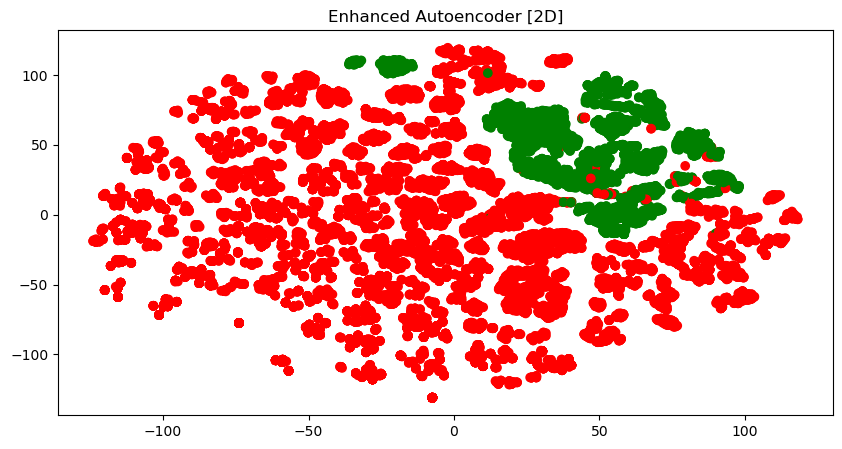

In [8]:
# Make enhanced autoencoder models with the following improvements:
# 1) Increased hidden layer capacity (hidden_dims=25)
# 2) Enable dropout to prevent over-fitting (dropout_ratio=0.1)
enc_model_2, dec_model_2 = make_ae_models(
    feat_dims=kdd_feat_std.shape[1],
    hidden_dims=25,
    bottleneck_dims=10,
    dropout_ratio=0.1,
    device=torch_device
)


# Create optimizer for autoencoder models (fixed learning rate)
optimizer = AdamW(
    chain(enc_model_2.parameters(), dec_model_2.parameters()),
    lr=0.01
)

# Train enhanced autoencoder models
# Enable L2 regularization of decoder output (bottleneck features) using:
train_autoencoder(
    enc_model_2, dec_model_2, optimizer, kdd_feat_std_tensor,
    n_epochs=50, batch_size=256,
    l2_reg_factor=0.001
)

# Perform dimensionality reduction with the encoder
with torch.inference_mode():
    kdd_feat_ae_2 = enc_model_2(kdd_feat_std_tensor)
    kdd_feat_ae_2 = kdd_feat_ae_2.cpu().numpy()

# Run 2D t-SNE on the autoencoder bottleneck features (kdd_feat_ae_2)
autoenc2_tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42,
)
kdd_feat_ae_2_tsne = autoenc2_tsne.fit_transform(kdd_feat_ae_2)

# Plot enhanced autoencoder bottleneck features (2D tsne)
visualize_samples(kdd_feat_ae_2_tsne, y_std, title="Enhanced Autoencoder")

## Clustering

The second part of this lab involves clustering analysis, or simply **clustering**. It is the task of grouping samples into multiple groups (called **clusters**) such that samples within the same group are more similar than samples from different groups. Clustering algorithms are **unsupervised learning** algorithms because grouping is solely based on the features, without the need of any labels, though you will see in the later part of this lab that labels can help evaluate clustering result.

Like the previous lab, a few utility functions are required to compute metrics for clustering result. The first one is `confusion_matrix`, which does exactly the same thing as `sklearn.metrics.confusion_matrix`, except it allows different number of classes in predictions and true labels. This makes it handy for clustering result because the number of clusters may not necessarily equal to the number of true classes.

In [9]:
def confusion_matrix(actuals, preds):
    """ Extension of `sklearn.metrics.confusion_matrix`, suitable for clustering results. """
    # Number of classes of predictions and true labels
    n_classes_actual = max(actuals)+1
    n_classes_pred = max(preds)+1
    # Confusion matrix
    matrix = np.zeros((n_classes_pred, n_classes_actual), dtype=int)

    # Update matrix count for each sample
    for pred, actual in zip(preds, actuals):
        matrix[pred][actual] += 1

    return matrix

The second function computes the overall entropy of clustering result, when the true labels are available. Assume we have $c$ classes and $k$ clusters $\Omega = {\omega_1, \dots, \omega_k}$, the in-cluster entropy for cluster $i$ can be computed by:

$$
H(\omega_i) = -\sum_{j=1}^c \frac{|\omega_{ij}|}{|\omega_i|} \log \frac{|\omega_{ij}|}{|\omega_i|}
$$

where $\omega_{ij}$ represents samples that belong to both cluster $i$ and class $j$. The overall entropy of clustering result, which is the weighted average of in-cluster entropy, can then be computed as:

$$
H(\Omega) = \sum_{i=1}^k \frac{|\omega_i|}{|\Omega|} H(\omega_i)
$$

Later you will see that the overall entropy of clustering result is a good metric to determine the amount of clusters.

In [10]:
# Epsilon for entropy computation
EPSILON = 0.01

def clustering_entropy(conf_matrix):
    """ Compute the entropy of classification result. """
    zero_items = conf_matrix==0
    # Add an epsilon to zero elements in confusion matrix
    if zero_items.any():
        conf_matrix = conf_matrix.astype(float)
        conf_matrix[zero_items] += EPSILON

    # In-cluster sample distributions
    in_cluster_dists = conf_matrix/np.sum(conf_matrix, axis=-1, keepdims=True)
    # Entropy of all clusters
    entropy_clusters = -np.sum(in_cluster_dists*np.log(in_cluster_dists), axis=-1)

    # Proportion of samples of each cluster
    sample_props = np.sum(conf_matrix, axis=-1)/np.sum(conf_matrix)
    # Overall clustering entropy
    return np.sum(sample_props*entropy_clusters)

### K-means (Centroid-based clustering)

Strictly speaking, **K-means clustering** refers to the problem of partitioning sample features in to $k$ clusters, in which each sample belongs to the cluster with the nearest mean (also known as **centroid**). K-means minimizes in-cluster variances (mean squared distance of sample to corresponding cluster centroid) when forming such $k$ clusters. Mathmatically, the loss function of K-means can be written as follows:

$$
l_{K-Means} = \arg \min_S \sum_{i=1}^k \sum_{\mathbf{x} \in S_i} ||\mathbf{x} - \mathbf{\mu}_i||_2^2
$$

where $S$ represents the partition of all samples, $S_i$ represents cluster $i$, $\mu_i$ is the centroid (mean) of all samples within cluster $i$.

K-means itself is an NP-hard problem, meaning it's prohibitive to find the optimal partition. However in almost all cases, near optimal partition yielded by approximation algorithms would be good enough. The most commonly used algorithm to solve K-means problem is **Lloyd's algorithm**. It starts by randomly select $k$ cluster centers, then it alternates between two steps:

* Assignment: assign each sample to the cluster whose current center is the nearest.
* Update: for all samples within each cluster, recompute the center of clustering by setting it to the mean of all member samples.

The algorithm terminates when sample assignments no longer change. Later improvements, such as **K-means++ initialization**, further reduces the convergence time of the naive K-means algorithm.

In the following code cell, we run K-means clustering on raw `StandardScaler` features and t-SNE transformed `StandardScaler` features. Here let's set $k = 4$. We will compute the confusion matrix for both clustering results, then visualize the clustering result for t-SNE transformed `StandardScaler` features as it has only three dimensions:

K-Means (Raw features) started...
K-Means (Raw features) completed. Elapsed time: 0.14s

K-Means (AE-1) started...
K-Means (AE-1) completed. Elapsed time: 0.05s

K-Means (AE-2) started...
K-Means (AE-2) completed. Elapsed time: 0.04s

Confusion matrix of K-means on raw features:
 [[ 4403 14182]
 [   76  4356]
 [  272  1050]] 

Confusion matrix of K-means on autoencoder transformed features (AE-1):
 [[    2 14002]
 [ 1430    63]
 [  272  1048]
 [    0  4347]
 [  376    44]
 [  291    11]
 [  765    22]
 [ 1615    51]] 

Confusion matrix of K-means on autoencoder transformed features (AE-2):
 [[  35 3836]
 [   7 4341]
 [ 233    5]
 [2291  100]
 [  25  628]
 [   0 9562]
 [1871   49]
 [  17 1057]
 [ 272   10]] 

Figure(1000x500)
Figure(1000x500)


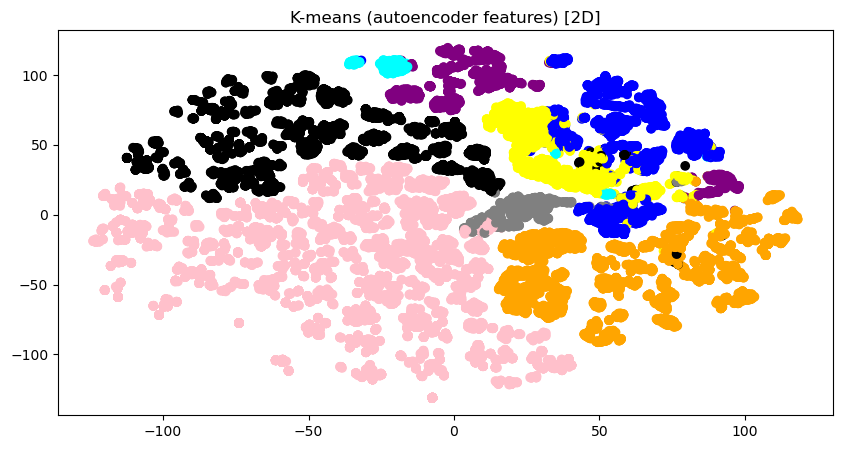

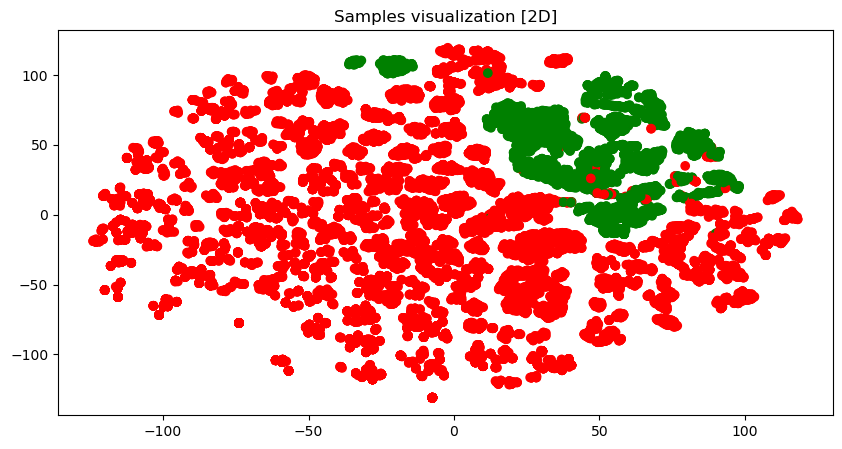

In [11]:
from sklearn.cluster import MiniBatchKMeans

# 1) K-means on raw StandardScaler features
k_means_std = MiniBatchKMeans(n_clusters=3, n_init="auto", random_state=87654321)
with timeit("K-Means (Raw features)"):
    pred_k_means_std = k_means_std.fit_predict(kdd_feat_std)

print("")
# 2) K-means on Autoencoder-1 bottleneck features
k_means_autoenc1 = MiniBatchKMeans(n_clusters=8, n_init="auto", random_state=87654321)
with timeit("K-Means (AE-1)"):
    pred_k_means_autoenc1 = k_means_autoenc1.fit_predict(kdd_feat_ae_1)

print("")
# 3) K-means on Autoencoder-2 bottleneck features
k_means_autoenc2 = MiniBatchKMeans(n_clusters=9, n_init="auto", random_state=87654321)
with timeit("K-Means (AE-2)"):
    pred_k_means_autoenc2 = k_means_autoenc2.fit_predict(kdd_feat_ae_2)


print("")
# Confusion matrix of clustering results
print(
    "Confusion matrix of K-means on raw features:\n",
    confusion_matrix(y_std, pred_k_means_std), "\n"
)
print(
    "Confusion matrix of K-means on autoencoder transformed features (AE-1):\n",
    confusion_matrix(y_std, pred_k_means_autoenc1), "\n"
)
print(
    "Confusion matrix of K-means on autoencoder transformed features (AE-2):\n",
    confusion_matrix(y_std, pred_k_means_autoenc2), "\n"
)

# Plot K-means clustering result for AE-2 t-SNE embedding
visualize_samples(
    kdd_feat_ae_2_tsne, pred_k_means_autoenc2,
    title="K-means (autoencoder features)",
    colors=["black", "orange", "purple", "blue", "grey", "pink", "yellow", "purple", "cyan"]
)

# Plot ground-truth labels on the same AE-2 t-SNE embedding
visualize_samples(kdd_feat_ae_2_tsne, y_std)


You might wonder why we are clustering different models into different $k$ clusters. Why not $k = 2$ (which is the number of true classes)? Why not all models use the same $k$? To answer this question, we need to look at two metrics, the mean squared error (MSE) and the overall entropy. The **mean squared error** of K-means clustering refers to the average squared distance from each sample to its corresponding cluster center. It does not depends on any true labels and can be used in a purely unsupervised scenario. Smaller MSE indicates better clustering performance. The **overall entropy** of clustering result, on the other hand, depends on the true labels of samples, and is usually used in semi-supervised scenarios. It indicates how "pure" each cluster is, or in other words, how samples from a cluster concentrate into a single true class. Clearly, we want "purer" clustering result with least number of clusters.

In [12]:
import matplotlib.pyplot as plt

# Number of samples
n_samples = len(y_std)
# Maximal number of clusters to try
k_max = 15

# K-means MSEs for each `k` value
k_means_mse = []
# Overall clustering entropy for each `k` value
k_means_entropy = []

for k in range(1, k_max + 1):
    if k % 5 == 0:
        print(f"Running K-means for k = {k}...")

    # Learn `k` clusters during K-means clustering
    k_means_autoenc_try = MiniBatchKMeans(n_clusters=k, n_init="auto", random_state=87654321)

    # Cluster enhanced autoencoder transformed StandardScaler features (AE-2)
    pred_k_means_autoenc_try = k_means_autoenc_try.fit_predict(kdd_feat_ae_2)

    # 1) Compute and store per-sample MSE for `k`
    k_means_mse.append(k_means_autoenc_try.inertia_ / n_samples)

    # 2) Compute and store clustering entropy for `k`
    conf_mat = confusion_matrix(y_std, pred_k_means_autoenc_try)
    k_means_entropy.append(clustering_entropy(conf_mat))


Running K-means for k = 5...
Running K-means for k = 10...
Running K-means for k = 15...


We have collected the mean squared error (MSE) and overall entropy for different number of K-means clusters. Now let's plot these metrics and see if we can find the best $k$ value:

Figure(2000x500)


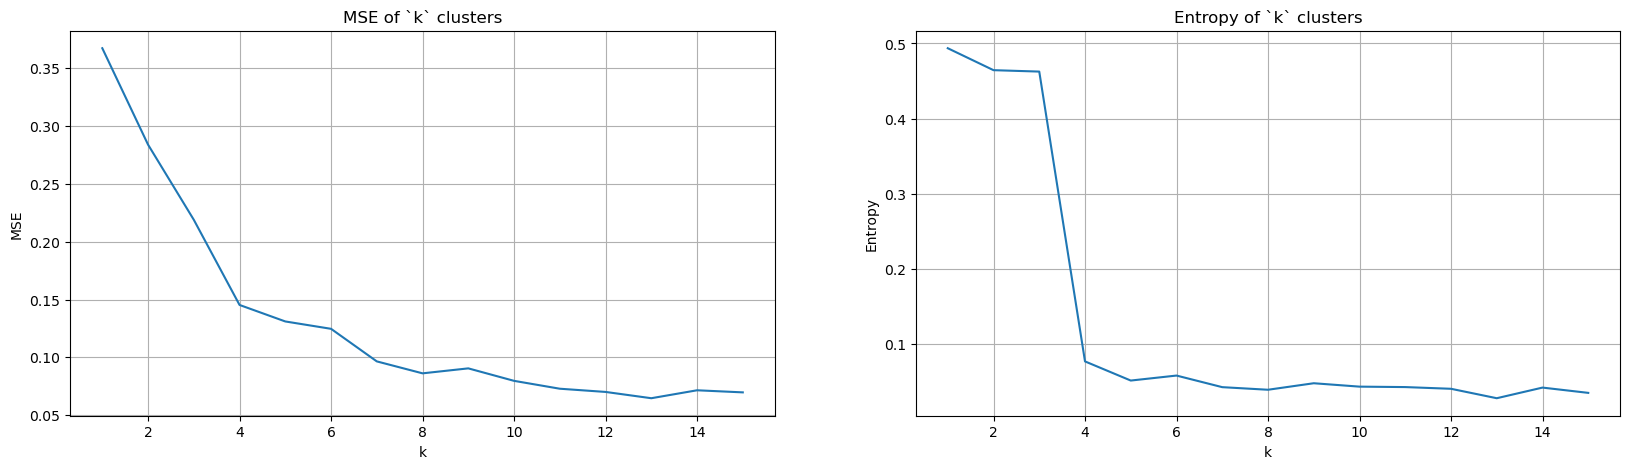

In [13]:
def plot_clustering_metrics(metrics_dict, fig_size=(20, 5)):
    """ Plot clustering metrics for different number of clusters. """
    # Number of metrics to plot
    n_metrics = len(metrics_dict)
    # Create plot for metrics
    fig = plt.figure(figsize=fig_size)

    for i, (metric_name, data) in enumerate(metrics_dict.items()):
        ax = fig.add_subplot(1, n_metrics, i+1)
        # Plot current metric on sub-plot
        ax.plot(np.arange(1, len(data)+1, dtype=int), data)

        # Title
        ax.set_title(f"{metric_name} of `k` clusters")
        # Axis labels
        ax.set_xlabel("k")
        ax.set_ylabel(metric_name)
        # Show grid
        ax.grid()

    # Show figure
    print(fig)

# Plot K-means MSE and clustering entropy
plot_clustering_metrics({
    "MSE": k_means_mse,
    "Entropy": k_means_entropy
})

The MSE plot does not show us anything useful, because MSE constantly decreases as the number of clusters increases. The overall entropy plot, on the other hand, gives us insights as we find $k = 4$ to be the local minimum of overall clustering entropy. This proves that partitioning samples into 4 clusters is a reasonable choice.

### Gaussian Mixture (Distribution-based Clustering)

Another popular clustering algorithm is Gaussian Mixture (GM) clustering, which utiltize **Gaussian mixture models**. A Gaussian mixture model is a mixture probability distribution consisting of several Gaussian distributions, each parameterized by mean $\mathbf{\mu}_i$ and variance $\mathbf{\Sigma}_i$. During training, we fit the Gaussian mixture model, such that its mixture proabability distribution matches the actual distribution of samples. This is done by iteratively performing **Expectation-Maximization (EM)**, which is somewhat similar to K-means:

* Expectation step (E step): compute the expected log likelihood of samples under the current mixture distribution.
* Maximization step (M step): maximize the expected log likelihood by adjusting distribution parameters.

When the EM algorithm converges, we compute the probability of all samples under each component Gaussian distribution. Then, the clustering category of a sample is determined by finding the Gaussian distribution under which the probability of the sample is the greatest.

In the following code cell, we run Gaussian Mixture clustering on raw `StandardScaler` features and t-SNE transformed `StandardScaler` features. We will set the number of clusters to 5. Again, we compute the confusion matrix for both clustering results, then visualize the clustering using for t-SNE transformed features:

Gaussian Mixture (Raw features) started...
Gaussian Mixture (Raw features) completed. Elapsed time: 3.31s

Gaussian Mixture (t-SNE) started...
Gaussian Mixture (t-SNE) completed. Elapsed time: 0.63s

Gaussian Mixture (t-SNE) started...
Gaussian Mixture (t-SNE) completed. Elapsed time: 1.06s

Confusion matrix of Gaussian Mixture on raw features:
 [[    2 13985]
 [    0  4270]
 [  236  1032]
 [  533   250]
 [ 3980    51]] 

Confusion matrix of Gaussian Mixture on autoencoder (AE-1) transformed features:
 [[    1 13975]
 [    0  4227]
 [    0  1015]
 [ 1620   263]
 [ 2823     0]
 [  307   108]] 

Confusion matrix of Gaussian Mixture on enhanced autoencoder (AE-2) transformed features:
 [[    1 13908]
 [    0  4262]
 [  127  1004]
 [  912   104]
 [  807   305]
 [ 2904     5]] 

Figure(1000x500)
Figure(1000x500)


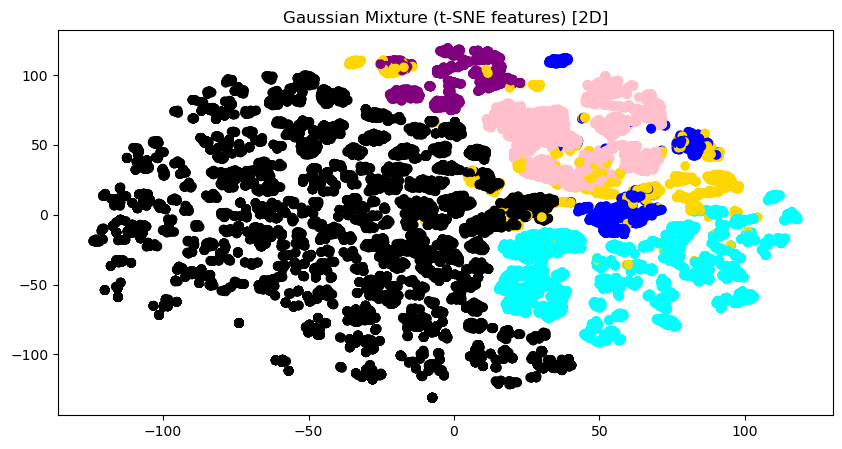

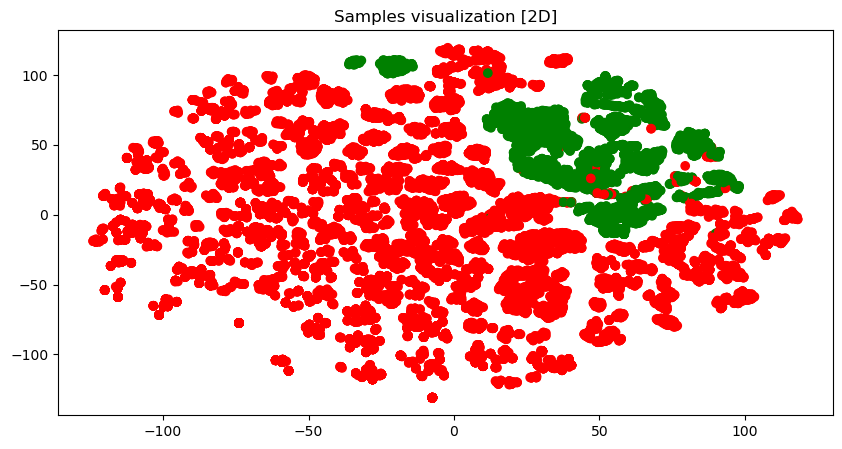

In [14]:
from sklearn.mixture import GaussianMixture

# Gaussian mixture clustering on raw `StandardScaler` features
# (Learn 4 clusters for all samples)
gm_std = GaussianMixture(n_components=5, random_state=87654321)
with timeit("Gaussian Mixture (Raw features)"):
    pred_gm_std = gm_std.fit_predict(kdd_feat_std)

print("")
# Gaussian mixture on autoencoder transformed `StandardScaler` features
gm_autoenc1 = GaussianMixture(n_components=6, random_state=87654321)
with timeit("Gaussian Mixture (t-SNE)"):
    pred_gm_autoenc1 = gm_autoenc1.fit_predict(kdd_feat_ae_1)

print("")

# Gaussian mixture on enhanced autoencoder transformed `StandardScaler` features
gm_autoenc2 = GaussianMixture(n_components=6, random_state=87654321)
with timeit("Gaussian Mixture (t-SNE)"):
    pred_gm_autoenc2 = gm_autoenc2.fit_predict(kdd_feat_ae_2)

print("")

# Confusion matrix of clustering results
print(
    "Confusion matrix of Gaussian Mixture on raw features:\n",
    confusion_matrix(y_std, pred_gm_std), "\n"
)
print(
    "Confusion matrix of Gaussian Mixture on autoencoder (AE-1) transformed features:\n",
    confusion_matrix(y_std, pred_gm_autoenc1), "\n"
)
print(
    "Confusion matrix of Gaussian Mixture on enhanced autoencoder (AE-2) transformed features:\n",
    confusion_matrix(y_std, pred_gm_autoenc2), "\n"
)

# Plot K-means clustering result for t-SNE transformed features
visualize_samples(
    kdd_feat_ae_2_tsne, pred_gm_autoenc2,
    title="Gaussian Mixture (t-SNE features)",
    colors=["black", "cyan", "purple", "blue", "gold","pink"]
)
visualize_samples(kdd_feat_ae_2_tsne, y_std)

Like K-means, we are interested in the best choice of number of clusters, so we compute and plot the overall clustering entropy for different number of clusters using the Gaussian Mixture clustering:

Running Gaussian Mixture for k = 5...
Running Gaussian Mixture for k = 10...
Running Gaussian Mixture for k = 15...
Figure(600x400)


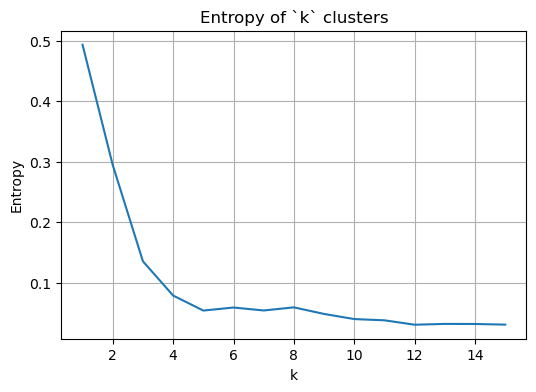

In [15]:
# Overall entropy for each `k` value
gm_entropy = []

# Maximal number of clusters to try
k_max = 15

for k in range(1, k_max+1):
    if k%5==0:
        print(f"Running Gaussian Mixture for k = {k}...")

    # Learn `k` clusters during gaussian mixture clustering
    gm_t_autoenc_try = GaussianMixture(n_components=k, random_state=87654321)
    # Cluster t-SNE transformed `StandardScaler` features
    pred_gm_autoenc_try = gm_t_autoenc_try.fit_predict(kdd_feat_ae_2)

    # Compute and store clustering entropy for `k`
    entropy_k = clustering_entropy(confusion_matrix(y_std, pred_gm_autoenc_try))
    gm_entropy.append(entropy_k)

# Plot overall clustering entropy for GM clustering results
plot_clustering_metrics({"Entropy": gm_entropy}, fig_size=(6, 4))

# 📝 Discussion Questions (Answer in this notebook)

> **Q1 (AE-2 + K-means): Choosing the number of clusters**  
> Using your **Entropy vs. k** plot for **K-means** on **AE-2 features**, justify the number of clusters **we chose** for AE-2.  
> In your justification, clearly refer to what you see in the plot.

> **Q2 (K-means): Best feature extraction method**  
> Using the **confusion matrices** you computed for **K-means**, decide which feature extraction method gives the best clustering results:  
> - raw standardized features (`kdd_feat_std`)  
> - AE-1 bottleneck features (`kdd_feat_ae_1`)  
> - AE-2 bottleneck features (`kdd_feat_ae_2`)  
> Explain your choice using specific patterns you observe in the confusion matrices.

> **Q3 (AE-2 + Gaussian Mixture): Choosing the number of clusters**  
> Using your **Entropy vs. k** plot for **Gaussian Mixture** on **AE-2 features**, justify the number of clusters **we chose** for AE-2.  
> Refer to what you see in the plot.

> **Q4 (Gaussian Mixture): Best feature extraction method**  
> Using the **confusion matrices** you computed for **Gaussian Mixture**, decide which feature extraction method gives the best clustering results:  
> - raw standardized features (`kdd_feat_std`)  
> - AE-1 bottleneck features (`kdd_feat_ae_1`)  
> - AE-2 bottleneck features (`kdd_feat_ae_2`)  
> Explain your choice using specific evidence from the confusion matrices.


## Discussion Answers

**Q1 (AE-2 + K-means): Choosing the number of clusters**

We chose k=9 for K-means on AE-2 features. Looking at the Entropy vs. k plot, the overall clustering entropy decreases as k increases and reaches a local minimum around k=9. Beyond this point, adding more clusters does not significantly reduce entropy (and may even increase it slightly), meaning that 9 clusters provide a good balance between cluster purity and the number of clusters. The "elbow" or local minimum at k=9 suggests it is a natural partitioning point for the AE-2 feature space.

**Q2 (K-means): Best feature extraction method**

The AE-2 bottleneck features give the best K-means clustering results. Comparing the confusion matrices: the raw standardized features (with k=3) produce clusters where normal and malicious samples are heavily mixed within the same clusters, resulting in impure groupings. The AE-1 features (with k=8) show some improvement, with certain clusters becoming more concentrated toward one class. The AE-2 features (with k=9) yield the cleanest separation — several clusters are dominated almost entirely by one class (either normal or malicious), indicating much higher cluster purity. The enhanced autoencoder's dropout regularization and L2 bottleneck regularization help it learn more discriminative compressed representations.

**Q3 (AE-2 + Gaussian Mixture): Choosing the number of clusters**

We chose k=6 for Gaussian Mixture on AE-2 features. From the Entropy vs. k plot for Gaussian Mixture clustering, the entropy drops sharply as k increases from 1 to about 5-6, then levels off or fluctuates without substantial further decrease. The value k=6 sits at or near a local minimum in entropy, making it a good choice — it achieves high cluster purity with a relatively small number of components. Going beyond 6 components does not meaningfully improve the clustering quality.

**Q4 (Gaussian Mixture): Best feature extraction method**

The AE-2 bottleneck features provide the best Gaussian Mixture clustering results. Examining the confusion matrices: the raw standardized features (k=5) show significant mixing of normal and malicious samples across clusters. The AE-1 features (k=6) improve the separation somewhat, but some clusters still contain substantial numbers of both classes. The AE-2 features (k=6) yield the most concentrated confusion matrix — clusters tend to be dominated by a single class, with much less cross-contamination. This indicates that the enhanced autoencoder (with larger hidden layers, dropout, and L2 regularization) produces bottleneck features that better capture the underlying structure separating normal from malicious traffic, enabling both K-means and Gaussian Mixture to form purer clusters.

## References

1. KDD Cup 1999 Dataset: https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
2. Autoencoder: https://en.wikipedia.org/wiki/Autoencoder
3. K-means clustering: https://en.wikipedia.org/wiki/K-means_clustering
4. Lloyd's algorithm: https://en.wikipedia.org/wiki/Lloyd%27s_algorithm
5. K-means++: https://en.wikipedia.org/wiki/K-means%2B%2B
6. Mixture model: https://en.wikipedia.org/wiki/Mixture_model
7. Expectation-Maximization (EM): https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm